# Diabetes Predictor Model - Modeling

### In this notebook we will:
### 1. Apply 2-3 different modeling methods
### 2. Apply model hyperparameter tuning methods
### 3. Define the metrics I use to choose my final model
### 4. Evaluate the performance of the different models 
### 5. Identify one of the models as the best model 

##### The main objective is to develop a binary classification model to predict if an individual has Diabetes using their personal and health indicators

### Imports

In [5]:
!pip install xgboost

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, \
confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, \
make_scorer, recall_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, RocCurveDisplay

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier, DMatrix

#show plots inline
%matplotlib inline

##### Since I have a binary classification problem, I am going to use the following modeling methods...
##### 1. XGBoost (tree-based model)
##### 2. K-Nearest Neighbors (KNN) (instance-based model)
##### 3. Support Vector Machine (SVM) (margin-based model)

### Loading the Data

In [11]:
# Reading the saved CSV's
# Using .squeeze() to turn my single-column DataFrame into a Series

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()   #Vinit doesn't do squeeze()

In [13]:
# Ensuring the shapes match

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(202944, 21) (202944,)
(50736, 21) (50736,)


In [15]:
print(X_train.dtypes)

HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object


In [17]:
print(y_train.dtypes)

int64


### XGBoost Model

In [20]:
# Creating a XGB pipeline
pipeline = Pipeline([
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        eval_metric='logloss',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [22]:
# Applying hyperparameter tuning
param_grid = {
    'xgb__n_estimators': [100, 200, 400],
    'xgb__learning_rate': [0.01, 0.03, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 1, 5],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [1, 5, 10]
}

In [24]:
# Using RandomizedSearchCV to determine the best hyperparameters for the XGB model

rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=1,
    verbose=2
)


rand.fit(X_train, y_train)
best_xgb = rand.best_estimator_

print("Best Score:" + str(rand.best_score_))
print("Best Parameters: " + str(rand.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   0.6s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   0.8s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   0.7s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.03, xgb__max_depth=3, xgb__min_child_weight=3, xgb__n_estimators=200, xgb__reg_alpha=1, xgb__reg_lambda=5, xgb__subsample=1.0; total time=   0.6s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.

In [26]:
# Getting predictions
y_pred = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     42741
           1       0.59      0.19      0.29      7995

    accuracy                           0.85     50736
   macro avg       0.73      0.58      0.60     50736
weighted avg       0.82      0.85      0.82     50736



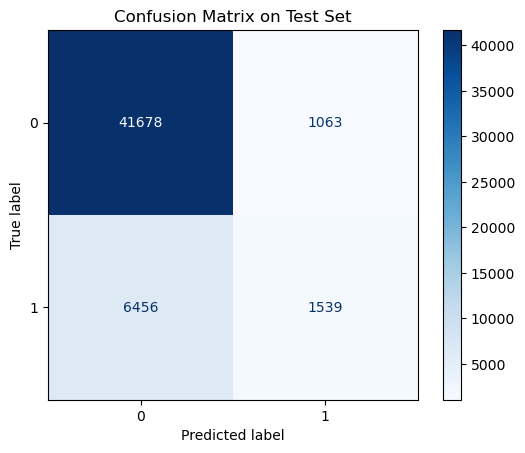

In [28]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

##### Based on the confusion matrix...
##### 1.) There are 41678 correct diabetes predictions
##### 2.) There are 1539 correct predictions for non-diabetes
##### 3.) There are 1063 diabetes predictions that are wrong
##### 4.) There are 6456 non-diabetes predictions that are wrong

In [31]:
# Calculating Accuracy
accuracy = best_xgb.score(X_test, y_test)

print(f'My XGBoost model accuracy is: {accuracy * 100:.2f}%')

My XGBoost model accuracy is: 85.18%


AUC Score: 0.8253595639011825.2f


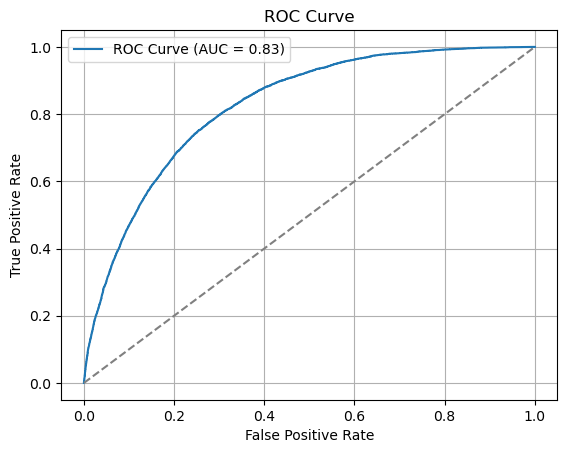

In [33]:
# Calculating the ROC for the XGBoost model

#Predicting probabilities
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calculating ROC curve
# fpr = false positive rate
# tpr = true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculating AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f'AUC Score: {auc_score}.2f')

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

##### An AUC score of 1 is a perfect model
##### An AUC score of 0.5 is no better than random

#### My AUC score is 0.81, indicating a good ability to distinguish the two classes (diabetic and non-diabetic)

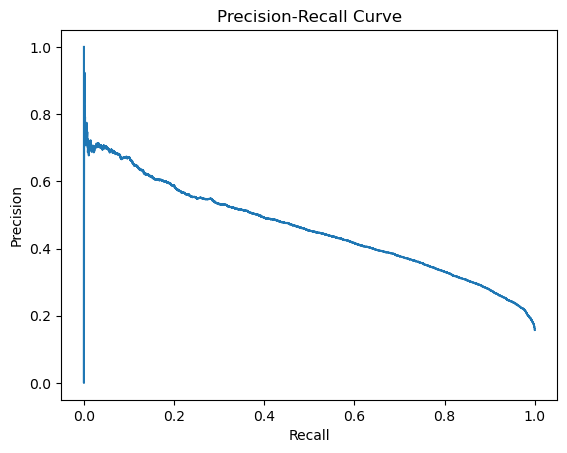

In [36]:
# Plotting my precision-recall curve
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

##### The x-axis is...of all true diabetics, what fraction you predicted as positive
##### The y-axis is...of all cases the model predicted positive, what fraction are actually diabetic

## K-Nearest Neighbors (KNN)

##### KNN is distance-based, so I must scale my features

In [41]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
param_grid = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance'],
}

In [45]:
# Instantiating RandomizedSearchCV
rand = RandomizedSearchCV(
    estimator=KNeighborsClassifier(algorithm='auto', n_jobs=1),
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting to training data
rand.fit(X_train_scaled, y_train)

# Examining best results
print(f'Best K: {rand.best_params_["n_neighbors"]}')
print(f'Best recall: {rand.best_score_}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best K: 10
Best recall: 0.8419465468306528


In [46]:
# Getting best KNN model
best_knn = rand.best_estimator_

In [47]:
# Getting predictions
y_pred = best_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42741
           1       0.50      0.15      0.23      7995

    accuracy                           0.84     50736
   macro avg       0.68      0.56      0.57     50736
weighted avg       0.80      0.84      0.80     50736



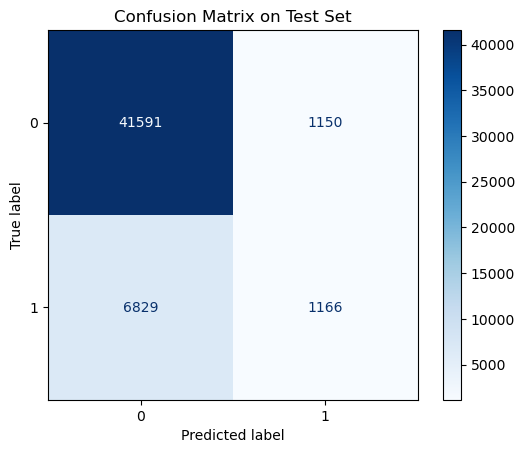

In [48]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

##### Based on the confusion matrix...
##### 1.) There are 41591 correct diabetes predictions
##### 2.) There are 1166 correct predictions for non-diabetes
##### 3.) There are 1150 diabetes predictions that are wrong
##### 4.) There are 6829 non-diabetes predictions that are wrong

In [50]:
# Calculating Accuracy
accuracy = best_knn.score(X_test_scaled, y_test)

print(f'My KNN model accuracy is: {accuracy * 100:.2f}%')

My KNN model accuracy is: 84.27%


## SVM

In [57]:
# Building a pipeline to scale and balance
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=False))
])

In [59]:
# Defining my hyperparameter search space
param_grid = {
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 0, 4)
}

In [61]:
# Setting up RandomizedSearchCV
rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=4,
    scoring='accuracy',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting
rand.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .....................n_neighbors=2, weights=uniform; total time=  40.2s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  41.6s
[CV] END ....................n_neighbors=4, weights=distance; total time=  41.5s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  44.2s
[CV] END .....................n_neighbors=7, weights=uniform; total time=  53.4s
[CV] END ....................n_neighbors=8, weights=distance; total time=  53.0s
[CV] END ....................n_neighbors=9, weights=distance; total time=  53.2s
[CV] END ......................svc__C=0.01, svc__gamma=0.001; total time=11.7min
[CV] END .....................n_neighbors=1, weights=uniform; total time=  40.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=  40.4s
[CV] END .....................n_neighbors=4, weights=uniform; total time=  43.1s
[CV] END ....................n_neighbors=5, weight

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svc__gamma': array([0.001, 0.01 , 0.1  , 1.   ])},
                   random_state=42, scoring='accuracy', verbose=2)

In [62]:
print("Best params:", rand.best_params_)
print("Best CV recall:", rand.best_score_)

Best params: {'svc__gamma': 0.01, 'svc__C': 0.1}
Best CV recall: 0.8429172579627877


In [65]:
# Getting best SVM model
best_svm = rand.best_estimator_

In [67]:
# Getting predictions
y_pred = best_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92     42741
           1       0.70      0.02      0.03      7995

    accuracy                           0.84     50736
   macro avg       0.77      0.51      0.47     50736
weighted avg       0.82      0.84      0.78     50736



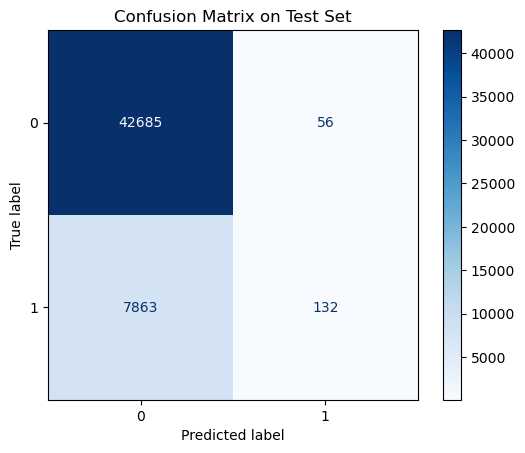

In [69]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

AUC: 0.723


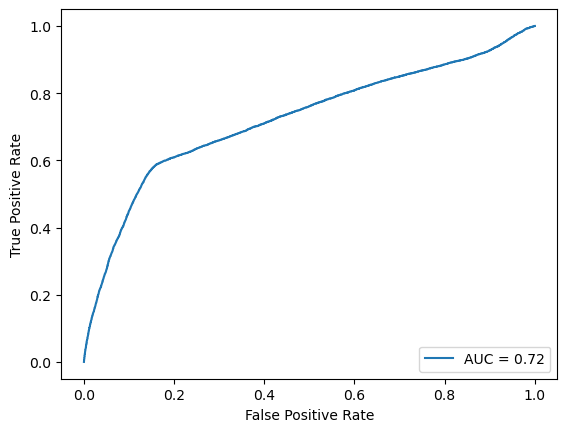

In [71]:
# Calculating the ROC for the SVM model

# Getting raw scores since I can't use predict_proba
y_scores = best_svm.decision_function(X_test)

# Computing ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

print(f'AUC: {roc_auc:.3f}')

# Plotting
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

## Deciding on Final Model

##### Comparing my XGBoost, KNN, and SVM model and I ultimately choose the XGBoost model.
##### The recall is the highest and the F1 score (harmonic mean of precision & recall) is the highest